# **<center><font style="color:rgb(100,109,254)">Module 1: Creating a Live Gesture Control Application</font> </center>**

<img src='https://drive.google.com/uc?export=download&id=10xY6U-4CecBuMkbONZp6bPx7BAZB6xfX'>

## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *Lesson 1: Introduction to hand landmark detection theory*

- ***Lesson 2:* Create a Hands Landmarks Detector** *(This Tutorial)*

- *Lesson 3:* Build a Hands Fingers Counter

- *Lesson 4:* Build a Hand Gesture Recognizer

- *Lesson 5:* Distance measurement

- *Lesson 6:* Brightness, Saturation, Contrast Enhancement & Gamma Correction

- *Lesson 7:* Build the Final Application

**Please Note**, these Jupyter Notebooks are not for sharing; do read the Copyright message below the Code License Agreement section which is in the last cell of this notebook.
-Taha Anwar

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

First we will import the required libraries.

In [2]:
import cv2
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt


# Additional comments:
#           - In this part, we will be importing the necessary
#             packages. OpenCV will be responsible for the camera
#             while the mediapipe is for the detection of hand
#             landmarks. While the matplotlib is for plotting data


## **<font style="color:rgb(134,19,348)">Initialize the Hands Landmarks Detection Model</font>**

To use the Mediapipe's hands solution, we first have to initialize the hands class using the **`mp.solutions.hands`** syntax and then we will have to call the function **`mp.solutions.hands.Hands()`** with the arguments explained below:

* **`static_image_mode`** - It is a boolean value that is if set to `False`, the solution treats the input images as a video stream. It will try to detect hands in the first input images, and upon a successful detection further localizes the hand landmarks. In subsequent images, once all **`max_num_hands`** hands are detected and the corresponding hand landmarks are localized, it simply tracks those landmarks without invoking another detection until it loses track of any of the hands. This reduces latency and is ideal for processing video frames. If set to `True`, hand detection runs on every input image, ideal for processing a batch of static, possibly unrelated, images. Its default value is `False`.


* **`max_num_hands`** - It is the maximum number of hands to detect. Its default value is `2`.


* **`min_detection_confidence`** - It is the minimum detection confidence `([0.0, 1.0])` required to consider the palm-detection model's prediction correct. Its default value is `0.5` which means that all the detections with prediction confidence less than 50% are ignored by default. 


* **`min_tracking_confidence`** - It is the minimum tracking confidence `([0.0, 1.0])` required to consider the landmark-tracking model's tracked hands landmarks valid. If the confidence is less than this argument value then the detector is invoked again in the next frame/image, so increasing its value increases the robustness, but also increases the latency. Its default value is `0.5`.

We will be working with images and videos as well, so we will have to set up the **`mp.solutions.hands.Hands()`** function two times. Once with the argument **`static_image_mode`** set to `True` to use with images and the second time **`static_image_mode`** set to `False` to use with videos.

Then we will also need to initialize the **`mp.solutions.drawing_utils`** class that is very useful to visualize the landmarks on the images/frames.

In [3]:
# Initialize the mediapipe hands class.
mp_hands = mp.solutions.hands

# Set up the Hands functions for images and videos.
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)
hands_videos = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.8)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils


# Additional comments:
#       - In this program, we are specifically trying to detect the hand.
#         As such, we only need to use the mp.solutions.hands
#         But in other programs, you might need to use other solutions
#         offered by mediapipe (whole body, face, etc.)

## **<font style="color:rgb(134,19,348)">Create a Hands Landmarks Detection Function</font>**

Now we will create a function that will perform hands landmarks detection on an image and will visualize the resultant image along with the original image (using the [**`matplotlib`**](https://matplotlib.org/stable/index.html) library) or return the resultant image along with the output of the model depending upon the passed arguments.

To perform the hands landmarks detection, we will pass the image to the hand's landmarks detection machine learning pipeline by using the function **`mp.solutions.hands.Hands().process()`**. But first, we will have to convert the image from **`BGR`** to **`RGB`** format using the function [**`cv2.cvtColor()`**](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) as OpenCV reads images in **`BGR`** format and the ml pipeline expects the input images to be in **`RGB`** color format.

The machine learning pipeline outputs an object that has an attribute **`multi_hand_landmarks`** that contains the **twenty-one landmarks** of the prominent hand(s) in the image. Each landmark has:

* **`x`** : It is the landmark x-coordinate normalized to [0.0, 1.0] by the image width.


* **`y`**: It is the landmark y-coordinate normalized to [0.0, 1.0] by the image height.


* **`z`**: It is the landmark z-coordinate normalized to roughly the same scale as **`x`**. It represents the landmark depth with the wrist being the origin, so the smaller the value the closer the landmark is to the camera.

**Note:** *The z-coordinate is just the relative distance of the landmark from the wrist, and this distance increases and decreases depending upon the distance from the camera so that is why it represents the depth of each landmark point.*

We will draw the detected landmarks on a copy of the input image using the function **`mp.solutions.drawing_utils.draw_landmarks()`** and will also visualize the landmarks in three-dimensions (3D) using the function **`mp.solutions.drawing_utils.plot_landmarks()`**. For the 3D visualization, we will need the **`multi_hand_world_landmarks`** that is another attribute of the output object and contains a list of hands landmarks in world (3D) coordinates (in meters) with the origin at the hand’s approximate geometric center.

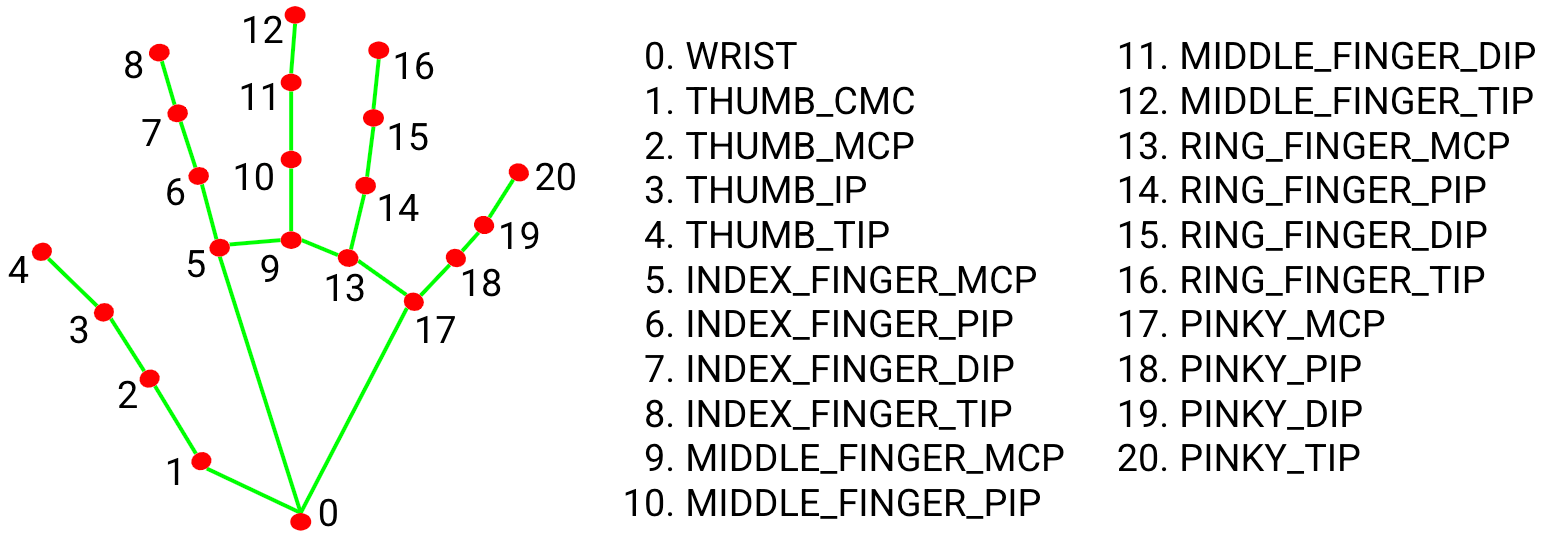

In [9]:
def detectHandsLandmarks(image, hands, draw=True, display=True):
    '''
    This function performs hands landmarks detection on an image.
    Args:
        image:   The input image with prominent hand(s) whose landmarks needs to be detected.
        hands:   The Mediapipe's Hands function required to perform the hands landmarks detection.
        draw:    A boolean value that is if set to true the function draws hands landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, and the output 
                 image with hands landmarks drawn if it was specified and returns nothing.
    Returns:
        output_image: A copy of input image with the detected hands landmarks drawn if it was specified.
        results:      The output of the hands landmarks detection on the input image.
    '''
    
    # Create a copy of the input image to draw landmarks on.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Hands Landmarks Detection.
    results = hands.process(imgRGB)
    
    # Check if landmarks are found and are specified to be drawn.
    if results.multi_hand_landmarks and draw:
        
        # Iterate over the found hands.
        for hand_landmarks in results.multi_hand_landmarks:
            
            # Draw the hand landmarks on the output image.
            mp_drawing.draw_landmarks(image = output_image, 
                                      landmark_list = hand_landmarks,
                                      connections = mp_hands.HAND_CONNECTIONS,
                                      landmark_drawing_spec=mp_drawing.
                                      DrawingSpec(color=(255,255,255),
                                                  thickness=4, circle_radius=6),
                                      connection_drawing_spec=mp_drawing.
                                      DrawingSpec(color=(255,255,0),
                                                  thickness=4))
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Iterate over the found hands.
        for hand_world_landmarks in results.multi_hand_world_landmarks:
            
            # Plot the hand landmarks in 3D.
            mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
        
    # Otherwise
    else:
        
        # Return the output image and results of hands landmarks detection.
        return output_image, results              

Now we will read some sample images using the function [**`cv2.imread()`**](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) and then utilize the function **`detectHandsLandmarks()`** created above to perform hands landmarks detection on them and display the results.

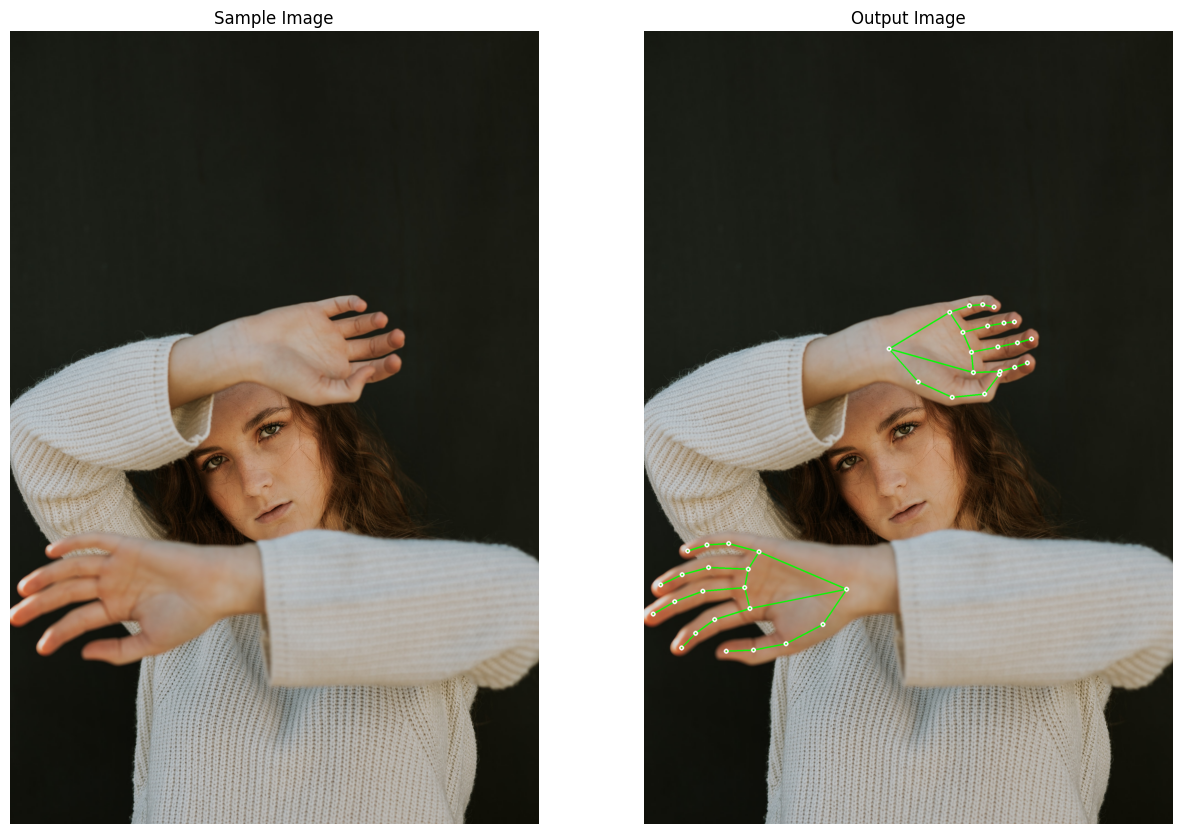

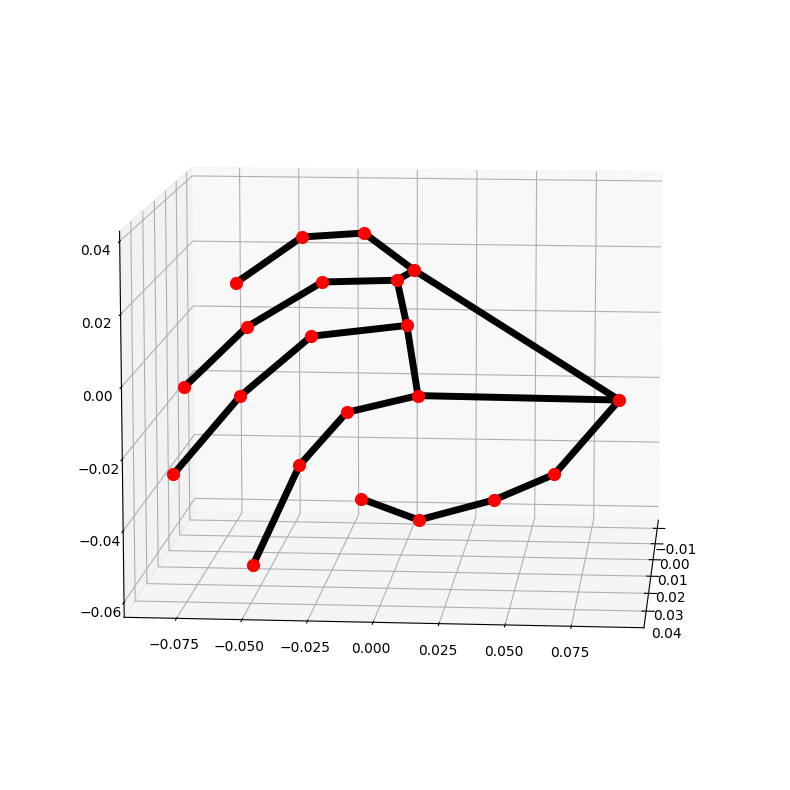

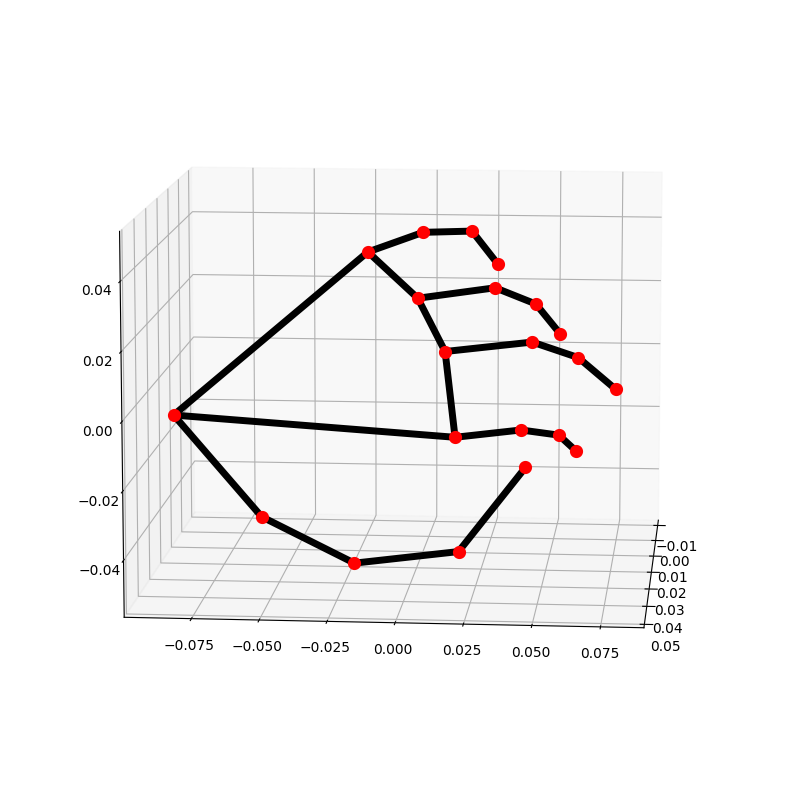

In [5]:
# Read a sample image and perform hands landmarks detection on it.
image = cv2.imread('media/sample1.jpg')
detectHandsLandmarks(image, hands, display=True)


# Additional Comments:
#       - Detect the landmarks on the hands and plot it on 3d
#       - By using the 3d plot, we can visualize the landmarks better.
#         We can infer in a 3d plot the depth (z) of the landmarks

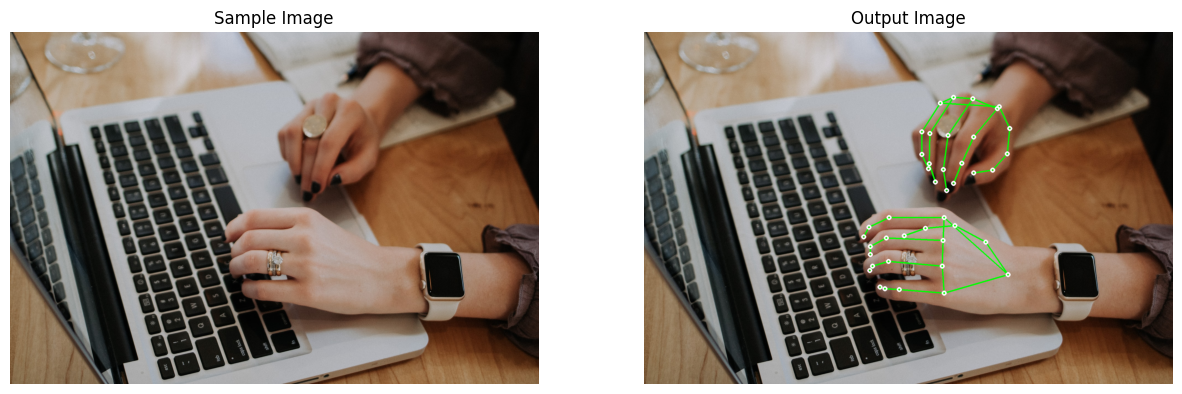

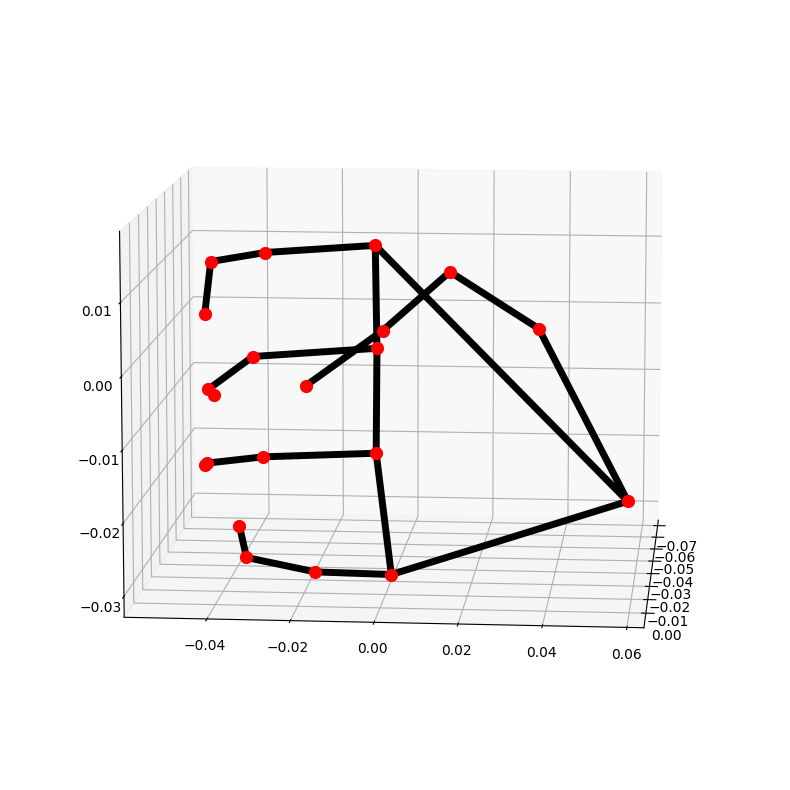

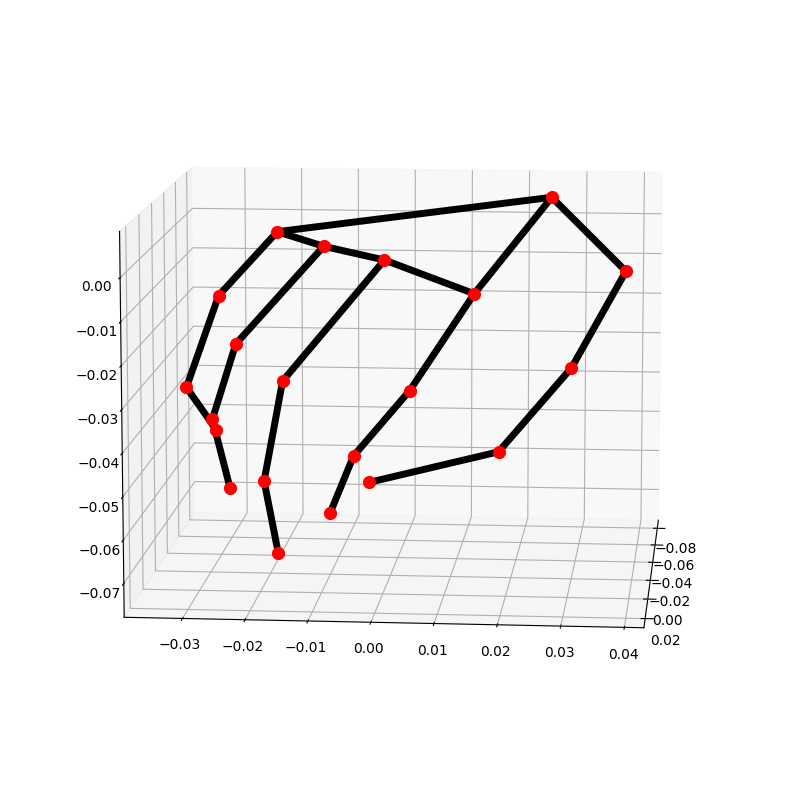

In [6]:
# Read another sample image and perform hands landmarks detection on it.
image = cv2.imread('media/sample2.jpg')
detectHandsLandmarks(image, hands, display=True)

# Additional comments:
#       - Mediapipe is so good that it can detect the hands even if 
#         the hand is on different angles

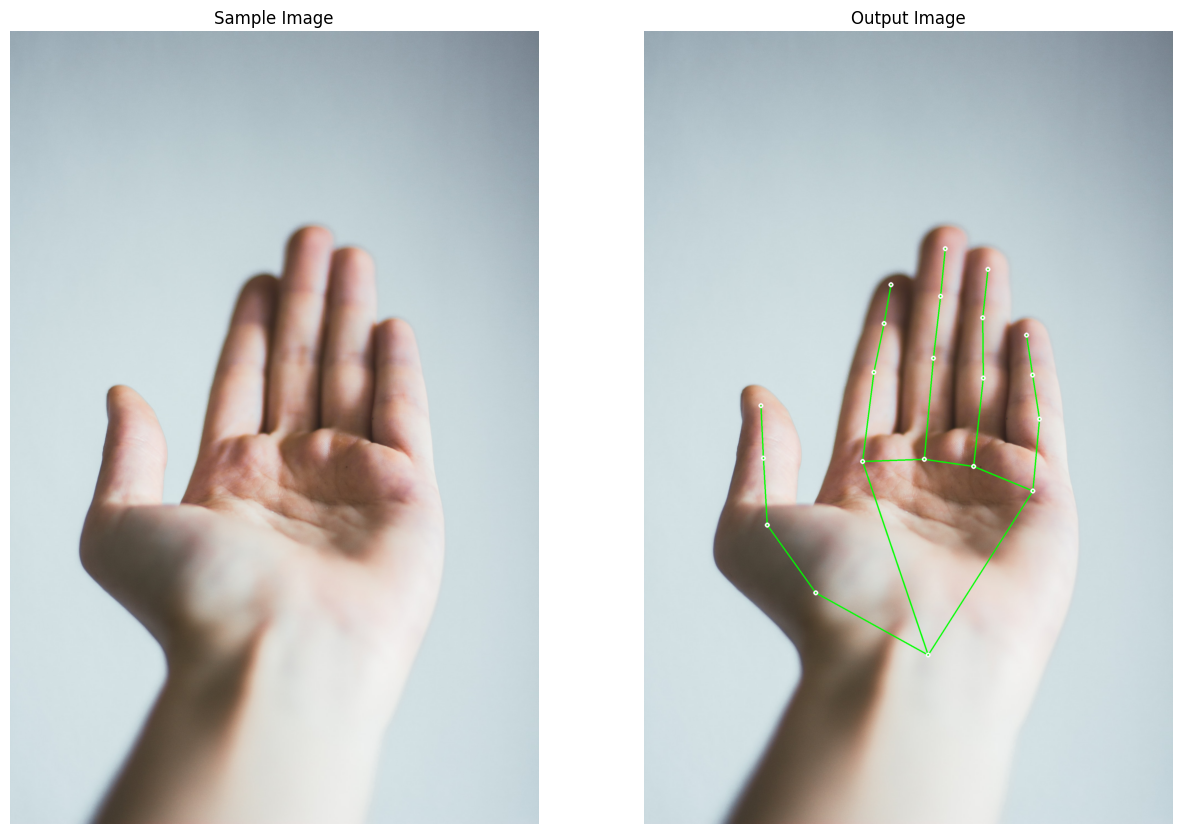

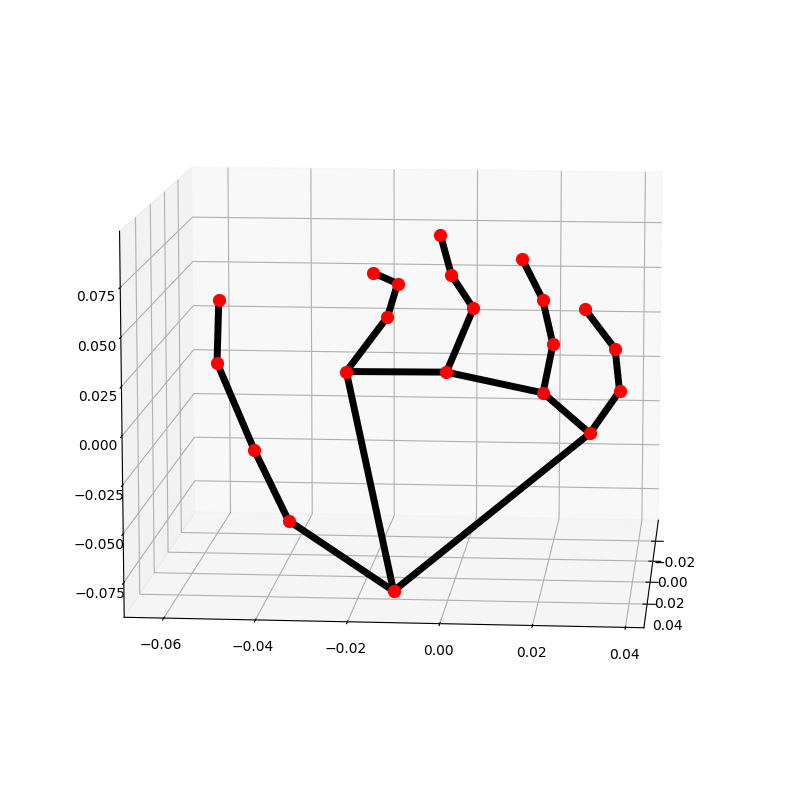

In [7]:
# Read another sample image and perform hands landmarks detection on it.
image = cv2.imread('media/sample3.jpg')
detectHandsLandmarks(image, hands, display=True)

# Additional comments:
#       - Here, we can better see the difference in perspective once the
#         landmarks has been plotted.

**Note:** *If you're interested in things like left, right hand detection, using the depth of hands or drawing bounding boxes around the hands, then watch [this tutorial](https://youtu.be/Af5Y9bBLA7s?list=PLCeWwpzjQu9hCnNBPkN-IZwQJb0sqWiP2)*

Great! it gave pretty accurate results for each of the sample images. Now, let's test this on a webcam feed in real-time.

In [12]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)

# I removed these since this was specifically used to deal
# with the instructor's HD cameras which I don't have hahahahaha
#camera_video.set(3,1280)
#camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Hands Landmarks Detection', cv2.WINDOW_NORMAL)

# Get the start time.
start_time = time()

# Initialize a variable to store the frame count.
frame_count = 0

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Increment the frame counter.
    frame_count += 1
        
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Perform Hands landmarks detection on the frame.
    frame, _ = detectHandsLandmarks(frame, hands_videos, display=False)
    
    # Calaculate average frames per second.
    ##################################################################################################
    
    # Get the current time.
    curr_time = time()
    
    # Check if the difference between the start and current time > 0 to avoid division by zero.
    if (curr_time - start_time) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = frame_count // (curr_time - start_time)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, int(frame_width/25)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/300), (255, 255, 0), int(frame_width/200))
    
    ##################################################################################################
           
    # Display the frame.
    cv2.imshow('Hands Landmarks Detection', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()


# Additional comments:
#       - Basically, we will be opening the camera, checking
#         whether the video stream is successfully being recorded.
#         If not, then terminate. If successful, proceed to flip the
#         image, so that it wont display the opposite view.
#       - After that, we will use the detect hands function to
#         detect and draw the hand landmarks and its connections.
#       - I made a slight adjustment on the code on the hand detection
#         and display

Woah! So this hand landmarks detector is accurate and fast as well. You will not need a high-end GPU to run this in real-time.

### **<font style="color:rgb(255,140,0)"> Code License Agreement </font>**
```
Copyright (c) 2022 Bleedai.com

Feel free to use this code for your own projects commercial or noncommercial, these projects can be Research-based, just for fun, for-profit, or even Education with the exception that you’re not going to use it for developing a course, book, guide, or any other educational products.

Under *NO CONDITION OR CIRCUMSTANCE* you may use this code for your own paid educational or self-promotional ventures without written consent from Taha Anwar (BleedAI.com).

```
